# 0. Setting Up

## 0.1 Mounting GDrive

In [ ]:
from google.colab import drive
import zipfile

drive.mount('/content/drive')

DIR = r'/content/drive/Shareddrives/Materijali 2023 2024/6. semestar/Mašinsko učenje/Vežbe/Domaci 2/ml_d2_x_y_z.zip'

with zipfile.ZipFile(DIR, 'r') as zip_ref:
    zip_ref.extractall()

Mounted at /content/drive


## 0.2 Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.special import boxcox1p
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

## 0.3 Loading Data

In [ ]:
DATA_DIR = 'ml_d2_x_y_z-2024/crop.csv'

df = pd.read_csv(DATA_DIR)

df.head()

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall,Crop
0,90,42,43,20.879744,82.002744,6.502985,202.935536,Rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,Rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,Rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,Rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,Rice


# 1. Feature Engineering

## 1.1 Splitting Features and Labels

In [ ]:
X = df.drop(columns=['Crop'])
y = df['Crop']

## 1.2 One-Hot Encoding the Labels

In [ ]:
y_onehot = pd.get_dummies(y)
y_onehot.shape

(2200, 22)

## 1.3 Setting up Transformations

In [ ]:
boxcox_cols = ['Potassium', 'Phosphorus', 'Rainfall']
log_cols = []

In [ ]:
def log_transform(X):
  X = X.apply(lambda x: np.log1p(x))
  return X

def boxcox_transform(X, lmbda=0.3):
  X = X.apply(lambda x: boxcox1p(x, lmbda))
  return X

# 2. Building the Neural Network

## 2.1 NN Class

In [ ]:
class NN:
  def __init__(self, fs, n_input, n_classes, n_hidden):

    assert len(n_hidden) == len(fs) - 1

    self.fs = fs
    self.n_classes = n_classes

    self.ws = {}
    self.bs = {}


    w_sizes = [(n_input, n_hidden[0])]

    for i in range(len(n_hidden) - 1):
        w_sizes.append((n_hidden[i], n_hidden[i + 1]))

    w_sizes.append((n_hidden[-1], n_classes))

    b_sizes = n_hidden
    b_sizes.append(n_classes)


    for idx, k in enumerate(fs.keys()):
      self.ws[k] = np.random.normal(size=(w_sizes[idx][0], w_sizes[idx][1]))
      self.bs[k] = np.random.normal(size=(b_sizes[idx]))
      #self.ws[k]  = tf.Variable(tf.random.normal([w_sizes[idx][0], w_sizes[idx][1]], dtype=tf.float64))
      #self.bs[k] = tf.Variable(tf.random.normal([b_sizes[idx]], dtype=tf.float64))

    self.v_dW = {k: np.zeros_like(w) for k, w in self.ws.items()}
    self.v_db = {k: np.zeros_like(b) for k, b in self.bs.items()}
    self.s_dW = {k: np.zeros_like(w) for k, w in self.ws.items()}
    self.s_db = {k: np.zeros_like(b) for k, b in self.bs.items()}


  def forward_prop(self, X, train=False):
    if train:
      caches = []
    a = X

    for k in self.fs.keys():

      z = np.dot(a, self.ws[k]) + self.bs[k]
      if train:
        caches.append((a, z))

      match self.fs[k]:
        case 'relu':
          a = self.relu(z)
        case 'sigmoid':
          a = self.sigmoid(z)
        case 'softmax':
          a = self.softmax(z)
        case 'tanh':
          a = self.tanh(z)
        case 'leaky_relu':
          a = self.leaky_relu(z)
        case _:
          raise Exception("Activation Function Not Found!")

    if train:
      self.caches = caches
    return a

  def relu(self, z):
    return np.maximum(0, z)

  def relu_derivative(self, x):
    return x >= 0

  def softmax(self, z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

  def softmax_derivative(self, x):
    sm = self.softmax(x)
    return np.diag(sm) - np.outer(sm, sm)

  def sigmoid(self, z):
    return 1.0 / (1.0 + np.exp(-z))

  def sigmoid_derivative(self, x):
    return self.sigmoid(x) * (1 - self.sigmoid(x))

  def tanh(self, z):
    return np.tanh(z)

  def tanh_derivative(self, x):
    return 1 - self.tanh(x) ** 2

  def leaky_relu(self, z, alpha=0.01):
    return np.where(z > 0, z, alpha * z)

  def leaky_relu_derivative(self, x, alpha=0.01):
    return np.where(x >= 0, 1, alpha)


  def compute_loss(self, y, y_hat):
    return -np.mean(np.sum(y * np.log(y_hat + self.epsilon), axis=1))

  def back_prop(self, X, y, y_hat, t):
    m = y.shape[0]
    grads = {}

    for k in self.ws.keys():
      grads[f'dW_{k}'] = np.zeros_like(self.ws[k])
      grads[f'db_{k}'] = np.zeros_like(self.bs[k])

    # Calcualating Gradients
    dA = y_hat - y

    out = True

    for k in reversed(list(self.fs.keys())):
      A_prev, Z = self.caches.pop()
      match self.fs[k]:
        case 'softmax':
          if out:
            dZ = dA
            out = False
          else:
            dZ = dA * self.softmax_derivative(Z)
        case 'relu':
          dZ = dA * self.relu_derivative(Z)
        case 'sigmoid':
          dZ = dA * self.sigmoid_derivative(Z)
        case 'tanh':
          dZ = dA * self.tanh_derivative(Z)
        case 'leaky_relu':
          dZ = dA * self.leaky_relu_derivative(Z)
        case _:
          raise Exception("Activation Function Not Found!")

      grads[f'dW_{k}'] = np.dot(A_prev.T, dZ) / m
      grads[f'db_{k}'] = np.sum(dZ, axis=0, keepdims=True) / m

      dA = np.dot(dZ, self.ws[k].T)

    # Adam Optimization
    for k in self.ws.keys():
      self.v_dW[k] = self.beta1 * self.v_dW[k] + (1 - self.beta1) * grads[f'dW_{k}'] # Momentum weight derivatives
      self.v_db[k] = self.beta1 * self.v_db[k] + (1 - self.beta1) * grads[f'db_{k}'] # Momentum bias derivatives
      self.s_dW[k] = self.beta2 * self.s_dW[k] + (1 - self.beta2) * grads[f'dW_{k}'] ** 2 # RMSProp weight derivatives
      self.s_db[k] = self.beta2 * self.s_db[k] + (1 - self.beta2) * grads[f'db_{k}'] ** 2 # RMSProp bias derivatives

      # Bias correction
      v_dW_corrected = np.reshape(self.v_dW[k]  / (1 - self.beta1 ** t), self.ws[k].shape)
      v_db_corrected = np.reshape(self.v_db[k] / (1 - self.beta1 ** t), self.bs[k].shape)
      s_dW_corrected = np.reshape(self.s_dW[k]  / (1 - self.beta2 ** t), self.ws[k].shape)
      s_db_corrected = np.reshape(self.s_db[k] / (1 - self.beta2 ** t), self.bs[k].shape)

      # Updating weights and biases
      self.ws[k] -= self.lr * v_dW_corrected / (np.sqrt(s_dW_corrected) + self.epsilon)
      self.bs[k] -= self.lr * v_db_corrected / (np.sqrt(s_db_corrected) + self.epsilon)

  def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32,
            lr=0.001, beta1=0.9, beta2=0.999, epsilon=1.0e-8):

    self.epochs = epochs
    self.lr = lr
    self.batch_size = batch_size
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.train_accs = []
    self.val_accs = []
    self. train_losses = []
    self.val_losses = []
    y_train = np.squeeze(np.eye(self.n_classes)[y_train.reshape(-1)])
    t = 0

    for epoch in range(1, epochs+1):
      print(f'Epoch {epoch}/{epochs}')
      # Permutation before splitting into mini-batches
      permutation = np.random.permutation(X_train.shape[0])
      X_shuffled = X_train[permutation]
      y_shuffled = y_train[permutation]

      for i in range(0, X_train.shape[0], self.batch_size):
        X_batch = X_shuffled[i:i + self.batch_size]
        y_batch = y_shuffled[i:i + self.batch_size]

        y_hat = self.forward_prop(X_batch, train=True)
        # loss = self.compute_loss(y_batch, y_hat)

        t += 1  # Increment the time step counter
        self.back_prop(X_batch, y_batch.astype(np.float64), y_hat, t)

      train_preds = self.predict(X_train)
      train_loss = self.compute_loss(y_train, np.squeeze(np.eye(self.n_classes)[train_preds.reshape(-1)]))
      train_acc = accuracy_score(np.argmax(y_train, axis=1), train_preds) * 100
      val_preds = self.predict(X_val)
      val_loss = self.compute_loss(np.squeeze(np.eye(self.n_classes)[y_val.reshape(-1)]), np.squeeze(np.eye(self.n_classes)[val_preds.reshape(-1)]))
      val_acc = accuracy_score(y_val, val_preds) * 100
      print(f'(Loss: Train: {train_loss:.4f} Val: {val_loss:.4f}\t Accuracy: Train: {train_acc:.3f}, Val: {val_acc:.3f})')

      self.train_losses.append(train_loss)
      self.val_losses.append(val_loss)
      self.train_accs.append(train_acc)
      self.val_accs.append(val_acc)

  def plot(self):
    step = self.epochs // 10
    plt.title('Train vs Val Accuracy')
    plt.plot(range(1, self.epochs+1), self.train_accs, c='blue', label='train')
    plt.plot(range(1, self.epochs+1), self.val_accs, c='red', label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.xticks(np.arange(0, self.epochs+step, step=step))
    plt.legend()
    plt.show()
    plt.title('Train vs Val Loss')
    plt.plot(range(1, self.epochs+1), self.train_losses, c='blue', label='train')
    plt.plot(range(1, self.epochs+1), self.val_losses, c='red', label='val')
    plt.xticks(np.arange(0, self.epochs+step, step=step))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
  def predict(self, X):
    return np.argmax(self.forward_prop(X), axis=1)

## 2.2 Applying Transformations

### 2.2.1 Applying BoxCox and Log Transformations

In [ ]:
from sklearn import preprocessing


if len(log_cols)>0:
  X[log_cols] = log_transform(X[log_cols])
if len(boxcox_cols)>0:
  X[boxcox_cols] = boxcox_transform(X[boxcox_cols])


### 2.2.2 Label Encoding the Target values, Normalization and Train-Test Splitting

In [ ]:
label_encoder = preprocessing.LabelEncoder()

y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 2.3 Building The Model

In [ ]:

n_input = 7
n_classes = 22
n_hidden = [32, 16]
fs = {
    '1': 'leaky_relu',
    '2': 'tanh',
    'out': 'softmax',
}

nn = NN(fs, n_input, n_classes, n_hidden)

nn.train(X_train, y_train, X_test, y_test, batch_size=64, epochs=100, lr=0.01)

Epoch 1/100
(Loss: Train: 12.0153 Val: 11.9734	 Accuracy: Train: 34.773, Val: 35.000)
Epoch 2/100
(Loss: Train: 7.2950 Val: 7.2427	 Accuracy: Train: 60.398, Val: 60.682)
Epoch 3/100
(Loss: Train: 3.9772 Val: 3.9353	 Accuracy: Train: 78.409, Val: 78.636)
Epoch 4/100
(Loss: Train: 2.5747 Val: 3.1399	 Accuracy: Train: 86.023, Val: 82.955)
Epoch 5/100
(Loss: Train: 1.9049 Val: 2.5956	 Accuracy: Train: 89.659, Val: 85.909)
Epoch 6/100
(Loss: Train: 1.5385 Val: 2.2189	 Accuracy: Train: 91.648, Val: 87.955)
Epoch 7/100
(Loss: Train: 1.2664 Val: 1.8839	 Accuracy: Train: 93.125, Val: 89.773)
Epoch 8/100
(Loss: Train: 0.9524 Val: 1.7165	 Accuracy: Train: 94.830, Val: 90.682)
Epoch 9/100
(Loss: Train: 0.6698 Val: 1.2560	 Accuracy: Train: 96.364, Val: 93.182)
Epoch 10/100
(Loss: Train: 0.5756 Val: 1.0048	 Accuracy: Train: 96.875, Val: 94.545)
Epoch 11/100
(Loss: Train: 0.4605 Val: 0.7536	 Accuracy: Train: 97.500, Val: 95.909)
Epoch 12/100
(Loss: Train: 0.5024 Val: 0.9210	 Accuracy: Train: 97.273, 

# 3. Plotting Model Results

## 3.1 Train vs Val Accuracy/Loss Over Time

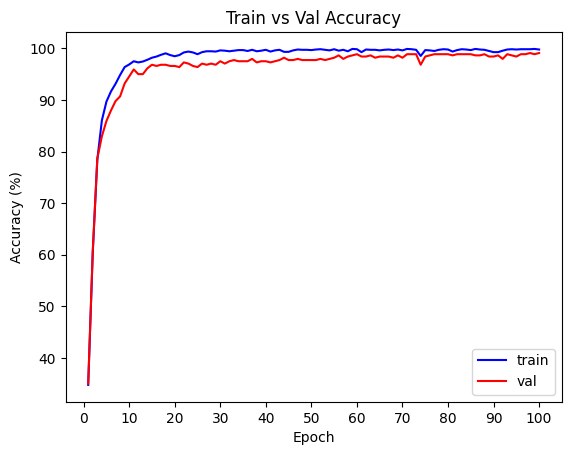

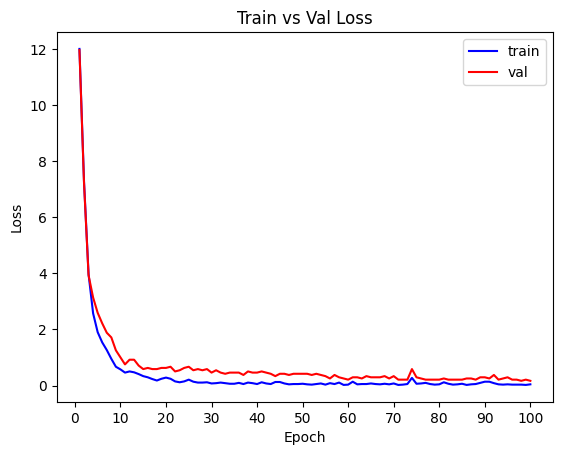

In [ ]:
nn.plot()

## 3.2 Final Test Accuracy, Classification Report & Confusion Matrix

Accuraacy: 0.990909090909091

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        23
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        17
           6       0.94      1.00      0.97        16
           7       1.00      1.00      1.00        18
           8       0.91      1.00      0.95        21
           9       0.95      1.00      0.98        20
          10       1.00      1.00      1.00        17
          11       1.00      0.94      0.97        18
          12       1.00      1.00      1.00        21
          13       1.00      1.00      1.00        25
          14       1.00      1.00      1.00        17
          15       1.00      1.00      1.00        23
          16       1.00     

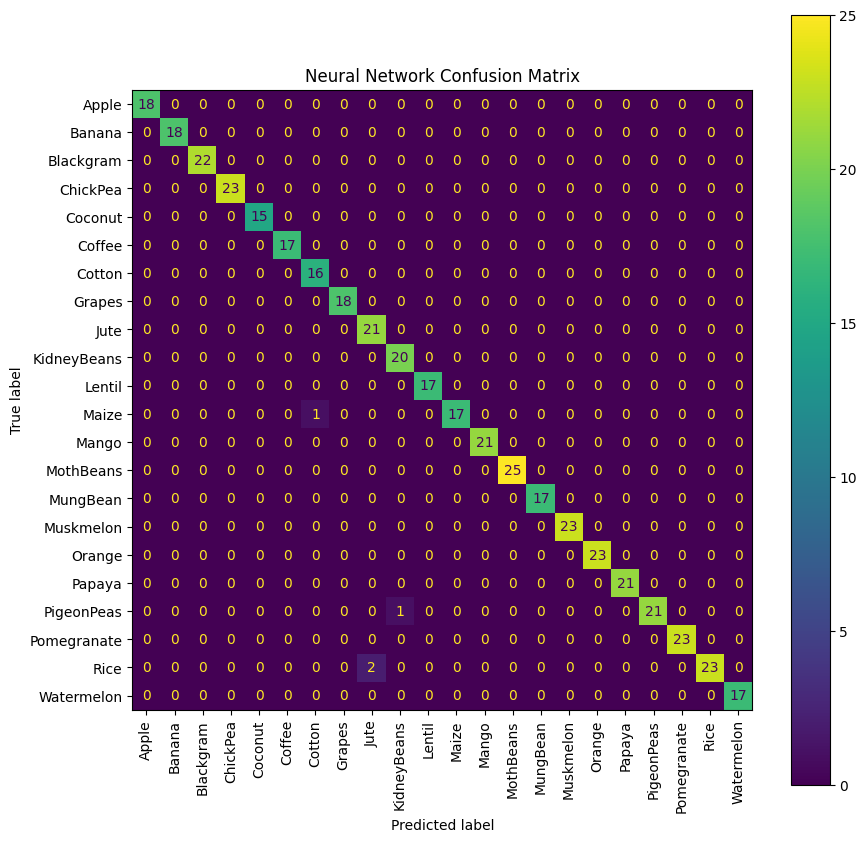

In [ ]:
y_preds = nn.predict(X_test)

print(f'Accuraacy: {accuracy_score(y_test, y_preds)}\n')

print('Classification report:')
print(classification_report(y_test, y_preds))

cm = confusion_matrix(y_test, y_preds, labels=np.unique(y))

fig, ax = plt.subplots(figsize=(10, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=sorted(df['Crop'].unique()))


disp.plot(ax=ax)
plt.xticks(rotation=90)
plt.title('Neural Network Confusion Matrix')
plt.show()